#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Этапы работы:

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделаем выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings 
warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('/Users/admin/Downloads/taxi.csv', index_col = [0], parse_dates = [0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
    
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Отсортируем по индексу, чтобы значения стояли подряд. Затем проверим, везде ли соблюдены равные интервалы

In [3]:
data = data.sort_index()

In [4]:
data.index.is_monotonic

True

Все в порядке. Далее произведем ресемплирование. Используем суммарное значение по каждому часу

In [5]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Мы получили значения за полгода - с 01 марта 2018 года до 31 августа 2018 года, сумму за каждый час этого периода.

## Анализ

Построим графики тренда и сезонности. Зададим два разных значения периода.

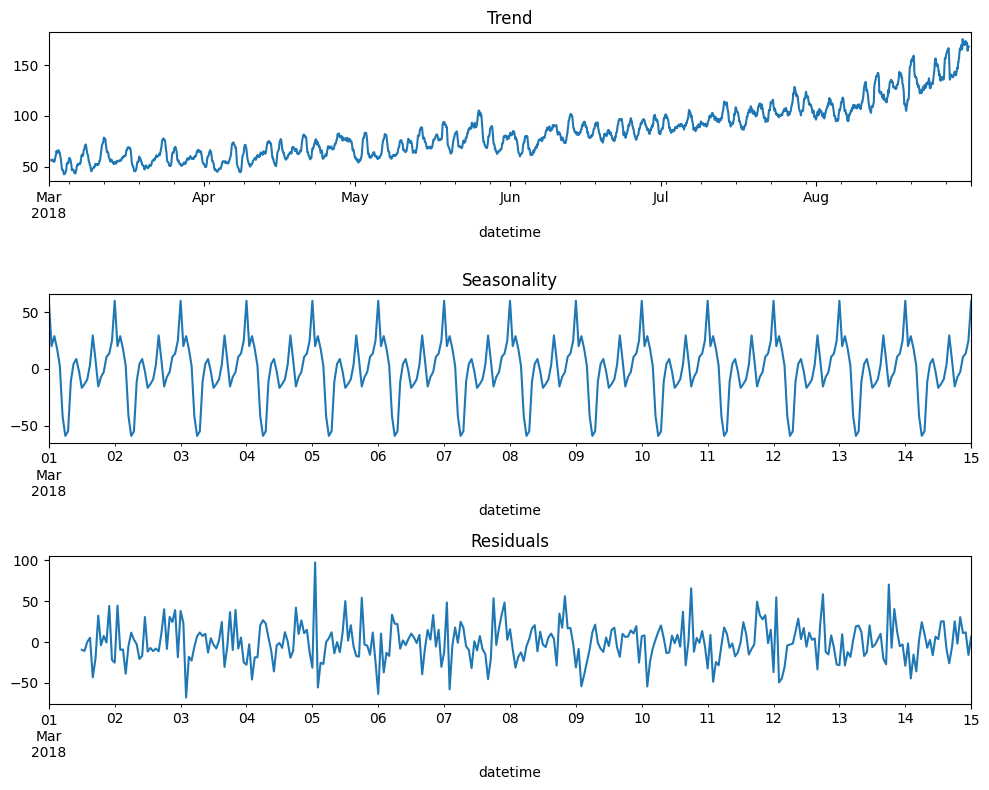

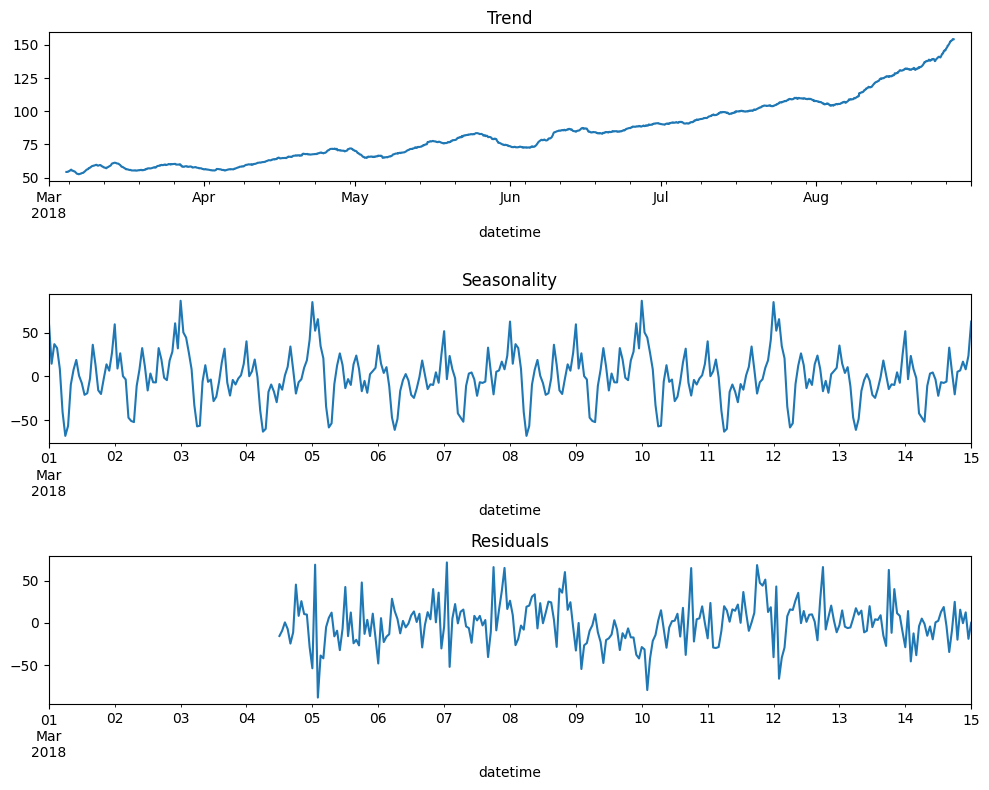

In [6]:
list_1 = [24, 24*7]
for i in list_1:
    
    decomposed = seasonal_decompose(data, period = i)
    plt.figure(figsize=(10, 8))

    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')

    plt.subplot(312)
    decomposed.seasonal['2018-03-01 00:00:00': '2018-03-15 00:00:00'].plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.subplot(313)
    decomposed.resid['2018-03-01 00:00:00': '2018-03-15 00:00:00'].plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

На графиках виден тренд к увеличению целвого признака.

## Обучение

Напишем функцию, которая создаст новые столбцы с признаками - календарные (день месяца, день недели), отстающие значения, скользящее среднее.

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data_copy = data
    data_copy['day'] = data.index.day
    data_copy['dayofweek'] = data.index.dayofweek
    
    l = [1, 24, 24*7]
    for lag in l:
        data_copy['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    return(data_copy)

In [8]:
make_features(data, 6, 5)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis =1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis =1)
target_test = test['num_orders']




In [9]:
def rmse(target, predicted):
    return (mean_squared_error(target, predicted)) ** 0.5

rmse_scorer = make_scorer(rmse, greater_is_better=False)

Первую модель возьмем -  линейную регрессию.

In [10]:
tscv = TimeSeriesSplit(n_splits=9)

model_lin = LinearRegression()
model_lin.fit(features_train, target_train)

scores = cross_val_score(model_lin,
                         features_train,
                         target_train,
                         cv = tscv,
                         scoring = rmse_scorer)
rmse_lin = scores.mean()*(-1)
print(rmse_lin)

22.750703232174445


Вторая модель - случайный лес

In [11]:
model_fr = RandomForestRegressor(random_state=12345)
param_search = {'max_depth' : range(1,3),
                 'n_estimators' : range(1,201,50),
                'min_samples_leaf': range (2,8,2)}


gsearch = GridSearchCV(estimator=model_fr, cv=tscv,
                        param_grid=param_search, verbose = False, scoring = rmse_scorer)
fr_tscv_model = gsearch.fit(features_train, target_train)

In [12]:
fr_rmse = round(fr_tscv_model.best_score_*-1)
print(fr_tscv_model.best_params_)
print(fr_rmse)

{'max_depth': 2, 'min_samples_leaf': 6, 'n_estimators': 51}
26


LGBMRegressor

In [13]:
param_grid = {
    'num_leaves': [10, 20, 31, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [10, 20, 50]
}
model_lgbm = LGBMRegressor()

grid_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, cv=tscv, scoring = rmse_scorer)
grid_lgbm.fit(features_train, target_train)
rmse_lgbm = round(grid_lgbm.best_score_*-1)
print(rmse_lgbm)
print(grid_lgbm.cv_results_)

23
{'mean_fit_time': array([0.01421981, 0.00904401, 0.0128102 , 0.01310145, 0.01133082,
       0.00793703, 0.01070979, 0.01289543, 0.0159852 , 0.02087993,
       0.01664888, 0.0230489 , 0.03203532, 0.03352102, 0.05606172,
       0.00874758, 0.0113954 , 0.01173859, 0.01066889, 0.01165666,
       0.02037713, 0.01203248, 0.01591627, 0.01603291, 0.01654193,
       0.01302722, 0.01900419, 0.03170938, 0.03107195, 0.05492393,
       0.00572814, 0.00714628, 0.01721658, 0.01228118, 0.0130727 ,
       0.01011989, 0.04195269, 0.01513402, 0.02091969, 0.03956554,
       0.02021294, 0.02432889, 0.04140857, 0.14403417, 0.08410528]), 'std_fit_time': array([0.01084576, 0.00162504, 0.00347513, 0.00313988, 0.00258656,
       0.0011866 , 0.0020269 , 0.00261468, 0.00475712, 0.00727554,
       0.00215896, 0.00421899, 0.00917615, 0.00664303, 0.02360941,
       0.00180799, 0.00232851, 0.00271015, 0.00219965, 0.00316077,
       0.01548464, 0.00207722, 0.00527738, 0.00393527, 0.00374471,
       0.00169033, 0.00

## Тестирование

Лучшей моделью оказалась линейная модель, rmse = 22,7. Ее проверим на тестовой выборке

In [14]:
predicted_test = model_lin.predict(features_test)
print("RMSE тестовой выборки: ", rmse (target_test, predicted_test))

RMSE тестовой выборки:  35.83360087690949


''

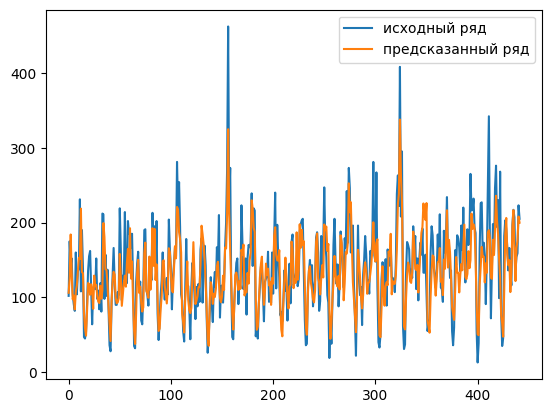

In [15]:
target_test = list(target_test)
predicted_test = list(predicted_test)

final = pd.DataFrame({'исходный ряд': target_test,
                        'предсказанный ряд' : predicted_test,
                        })


final.plot()
;

Выводы:

Линейная модель дала самый лучший результат на обучающей выборке, и приемлемый - на тестовой